In [0]:
! pip install kaggle


In [0]:
! mkdir -p ~/.kaggle/
! pwd
! mv kaggle.json ~/.kaggle/

/content


In [0]:
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
path = Config.data_path()/'retinaImages'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/retinaImages')

In [0]:
! kaggle competitions download -c aptos2019-blindness-detection

100% 8.01G/8.01G [01:39<00:00, 81.8MB/s]
100% 8.01G/8.01G [01:39<00:00, 86.6MB/s]
 99% 1.49G/1.50G [00:21<00:00, 62.3MB/s]
100% 1.50G/1.50G [00:21<00:00, 73.6MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 53.8MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 21.5MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 24.3MB/s]


In [0]:
! mv sample_submission.csv {path}/
! mv test.csv {path}/
! mv test_images.zip {path}/
! mv train.csv {path}/
! mv train_images.zip {path}/


In [0]:
! unzip -q -n {path}/train_images.zip -d {path}/train_images

In [0]:
! unzip -q -n {path}/test_images.zip -d {path}/test_images

In [1]:
df = pd.read_csv(path/'train.csv')
df.head()

NameError: ignored

In [0]:
df = pd.read_csv(path/'test.csv')
df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
! ls -ltr {path}/

total 9975620
-rw-r--r-- 1 root root 8602001734 Sep  9 15:33 train_images.zip
-rw-r--r-- 1 root root 1612694851 Sep  9 15:34 test_images.zip
-rw-r--r-- 1 root root      54948 Sep  9 15:34 train.csv
-rw-r--r-- 1 root root      25072 Sep  9 15:34 test.csv
-rw-r--r-- 1 root root      28938 Sep  9 15:34 sample_submission.csv
drwxr-xr-x 2 root root     135168 Sep  9 15:37 train_images
drwxr-xr-x 2 root root      69632 Sep  9 15:38 test_images


In [0]:
! ls {path}/train_images/

000c1434d8d7.png  4289af3afbd2.png  810ed108f5b7.png  be521870a0ea.png
001639a390f0.png  4294a14c656a.png  8114d6a160df.png  be68322c7223.png
0024cdab0c1e.png  42985aa2e32f.png  812d5adafaf2.png  be6cbf6e5b10.png
002c21358ce6.png  42a67337fa8e.png  81371b0c01ad.png  be7bc89f5fec.png
005b95c28852.png  42a850acd2ac.png  81704925f759.png  be7f791a7877.png
0083ee8054ee.png  42af7282349b.png  8185ce1cdcef.png  be8697eb2078.png
0097f532ac9f.png  42b08dca9b2f.png  81914ceb4e74.png  beb00fa6e7c9.png
00a8624548a9.png  42b93b574f23.png  8191ae701985.png  beb2ad14fd2d.png
00b74780d31d.png  42b9c1977681.png  81b0a2651c45.png  bebb3f167654.png
00cb6555d108.png  42c65af5ab16.png  81bc03e2ff2b.png  bebfbd907cac.png
00cc2b75cddd.png  42cc993f23a9.png  81d79d53ed7b.png  bec0acd539b2.png
00e4ddff966a.png  4318b6adeb97.png  8201cab8322d.png  bed8296c8dfe.png
00f6c1be5a33.png  4350a1b2f3cb.png  82088c6734e6.png  beeca5f14618.png
0104b032c141.png  435414ccccf7.png  821789e9053f.png  bf18ff30a8f6.png
0124df

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='train_images', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [0]:
#data classes
#data.c
data.classes
#len(data.classes)

['0', '1', '2', '3', '4']

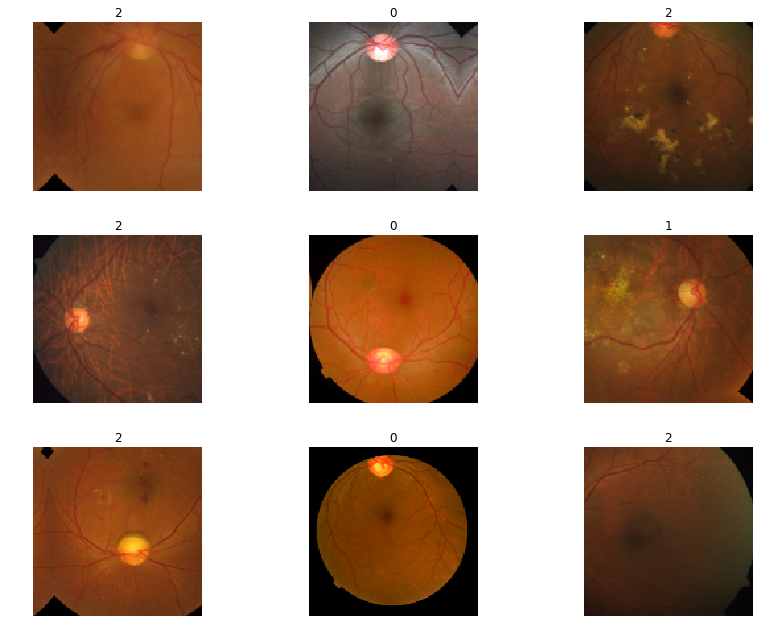

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
#accuracy at threshold of 0.2 , prints accuracy at threshold of 0.2 TODO: check different 0.2 
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 22029686.37it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


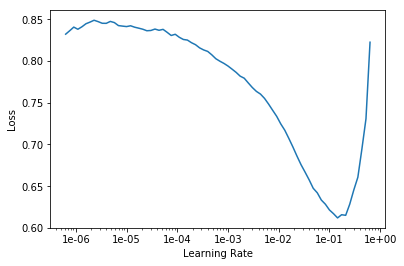

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.02

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.432647,0.287574,0.830055,0.794659,08:14
1,0.293887,0.229243,0.885792,0.808581,08:24
2,0.243127,0.205100,0.889891,0.820258,08:27
3,0.211751,0.209038,0.898361,0.825657,08:27
4,0.191362,0.197684,0.901093,0.831447,08:29


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (2930 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
4,1,0,0,4
Path: /root/.fastai/data/retinaImages;

Valid: LabelList (732 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
0,1,3,4,0
Path: /root/.fastai/data/retinaImages;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [0]:
class Interpretation():
    "Interpretation base class, can be inherited for task specific Interpretation classes"
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        self.data,self.preds,self.y_true,self.losses,self.ds_type, self.learn = \
                                 learn.data,preds,y_true,losses,ds_type,learn
        self.ds = (self.data.train_ds if ds_type == DatasetType.Train else
                   self.data.test_ds if ds_type == DatasetType.Test else
                   self.data.valid_ds if ds_type == DatasetType.Valid else
                   self.data.single_ds if ds_type == DatasetType.Single else
                   self.data.fix_ds)

    @classmethod
    def from_learner(cls, learn: Learner,  ds_type:DatasetType=DatasetType.Valid, activ:nn.Module=None):
        "Gets preds, y_true, losses to construct base class from a learner"
        preds_res = learn.get_preds(ds_type=ds_type, activ=activ, with_loss=True)
        return cls(learn, *preds_res)

    def top_losses(self, k:int=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."


In [0]:
  class My3_ClassificationInterpretation(Interpretation):
   
    def __init__(self, learn:Learner, preds:Tensor, y_true:Tensor, losses:Tensor, ds_type:DatasetType=DatasetType.Valid):
        super(My3_ClassificationInterpretation, self).__init__(learn,preds,y_true,losses,ds_type)
        self.pred_class = self.preds.argmax(dim=1)

    def confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            #self.y_true = self.y_true.float()
            self.y_true = self.y_true.float()
            for i in range(0, self.y_true.shape[0], slice_size):
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size].float()==x[:,None,None].float())).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", slice_size:int=1,
                              norm_dec:int=2, plot_txt:bool=True, return_fig:bool=None, **kwargs)->Optional[plt.Figure]:
        "Plot the confusion matrix, with `title` and using `cmap`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix(slice_size=slice_size)
        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fig = plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = np.arange(self.data.c)
        plt.xticks(tick_marks, self.data.y.classes, rotation=90)
        plt.yticks(tick_marks, self.data.y.classes, rotation=0)

        if plot_txt:
            thresh = cm.max() / 2.
            for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                coeff = f'{cm[i, j]:.{norm_dec}f}' if normalize else f'{cm[i, j]}'
                plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.grid(False)
        if ifnone(return_fig, defaults.return_fig): return fig

    def most_confused(self, min_val:int=1, slice_size:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix, presented as actual, predicted, number of occurrences."
        cm = self.confusion_matrix(slice_size=slice_size)
        np.fill_diagonal(cm, 0)
        res = [(self.data.classes[i],self.data.classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>=min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)


def _learner_interpret(learn:Learner, ds_type:DatasetType=DatasetType.Valid):
    "Create a `ClassificationInterpretation` object from `learner` on `ds_type` with `tta`."
    return ClassificationInterpretation.from_learner(learn, ds_type=ds_type)
Learner.interpret = _learner_interpret

In [0]:
#algorithm mistakes 
interpreter = My3_ClassificationInterpretation.from_learner(learn)
interpreter.most_confused(min_val=1)


[('0', '2', 1072),
 ('1', '0', 364),
 ('1', '2', 268),
 ('0', '1', 212),
 ('0', '4', 140),
 ('0', '3', 48),
 ('1', '4', 35),
 ('1', '3', 12)]

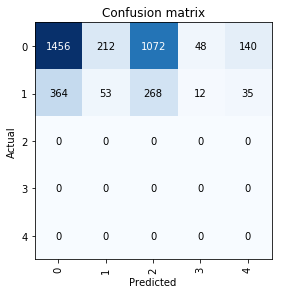

In [0]:
#confusion matrix

#interp = ClassificationInterpretation.from_learner(learn)
#losses,idxs = interp.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)
interpreter1 = My3_ClassificationInterpretation.from_learner(learn)
interpreter1.plot_confusion_matrix()
#losses,idxs = interpreter1.top_losses()
#len(data.valid_ds)==len(losses)==len(idxs)

Fine Tuning :

In [0]:
learn.unfreeze()

In [0]:
#learn.lr_find()
#learn.recorder.plot()


In [0]:
learn.fit_one_cycle(5, slice(1e-4,1e-3)) #lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.654607,0.494565,0.399454,0.619956,08:16
1,0.506715,0.276120,0.708743,0.781784,08:18
2,0.353571,0.219865,0.865574,0.843539,08:18
3,0.261225,0.189524,0.887705,0.860493,08:22
4,0.213061,0.184695,0.888251,0.858867,08:20


In [0]:
learn.save('stage-2-rn50')

In [0]:
! pwd

/content


In [0]:
#confusion matrix

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)